In [1]:
#| default_exp activations

# Activation Stats

In [2]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [3]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

/home/umangkaushik/mambaforge/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [6]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [7]:
from torcheval.metrics import MulticlassAccuracy

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [9]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


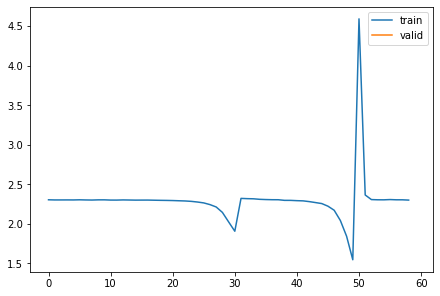

In [11]:
set_seed(69)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

### Manual Insertion

In [12]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


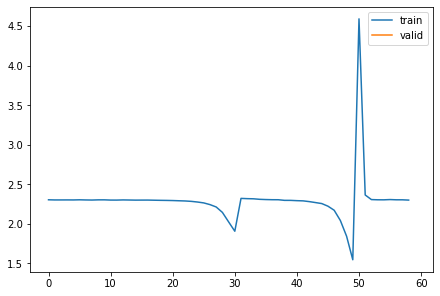

In [13]:
set_seed(69)
model = SequentialModel(*cnn_layers())
learn = fit(model)

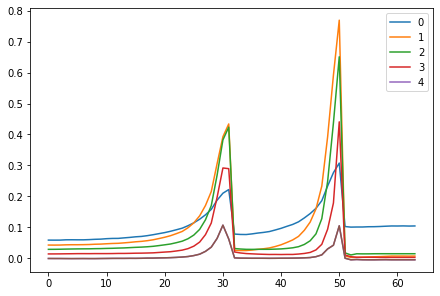

In [14]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

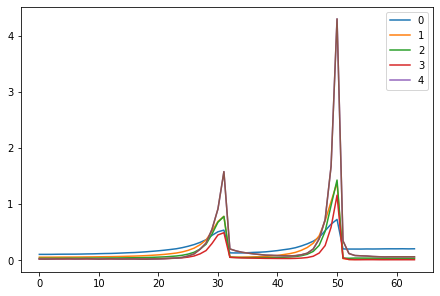

In [15]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### Pytorch Hooks

In [16]:
set_seed(69)
model = nn.Sequential(*cnn_layers())

In [17]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [18]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [19]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


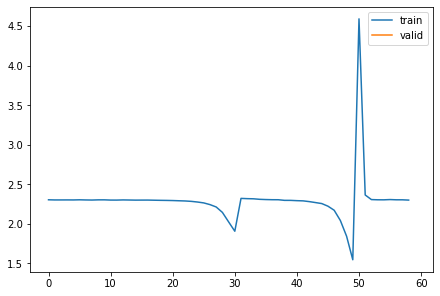

In [20]:
fit(model)

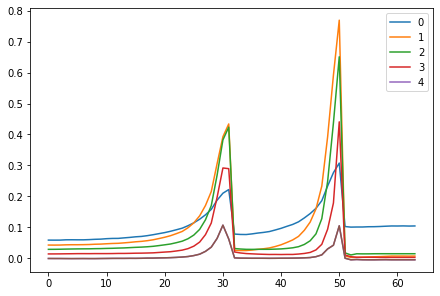

In [21]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook Class

In [22]:
#|export
class Hook():
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [23]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [24]:
set_seed(69)
model = nn.Sequential(*cnn_layers())

In [25]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


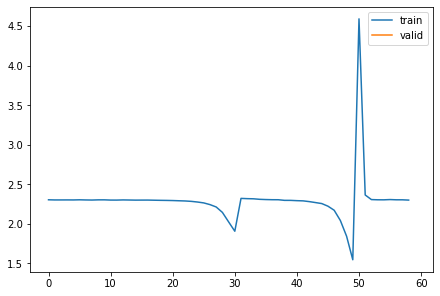

In [26]:
learn = fit(model)

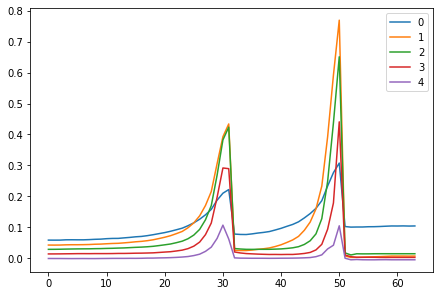

In [27]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

### Hooks Class

In [38]:
#|export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [39]:
set_seed(69)
model = nn.Sequential(*cnn_layers())

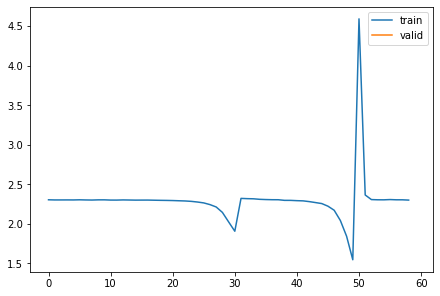

Exception ignored in: <function Hooks.__del__ at 0x7febc533fee0>
Traceback (most recent call last):
  File "/tmp/ipykernel_18115/3597042703.py", line 6, in __del__
  File "/tmp/ipykernel_18115/3597042703.py", line 11, in remove
AttributeError: 'Hooks' object has no attribute 'h'


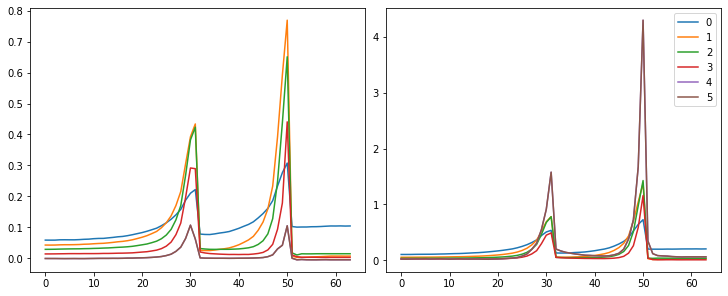

In [40]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        for i in 0, 1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback

In [41]:
#|export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
        
    def before_fit(self, learn):
        if self.mods: mods = self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
        
    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)
    
    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [42]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


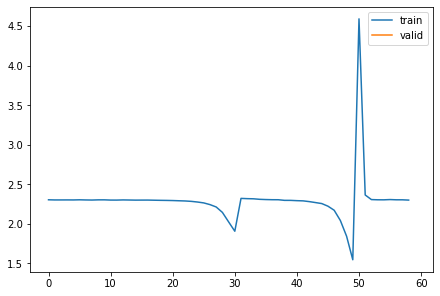

In [43]:
set_seed(69)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

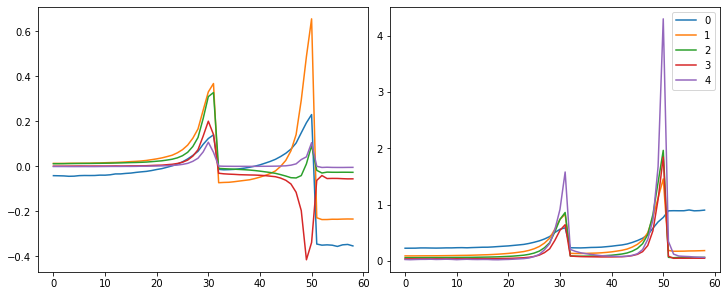

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hc:
    for i in 0, 1: axs[i].plot(h.stats[i])
plt.legend(range(6));

### Histograms

In [46]:
#|export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

accuracy,loss,epoch,train
0.158,2.298,0,train
0.204,2.035,0,eval


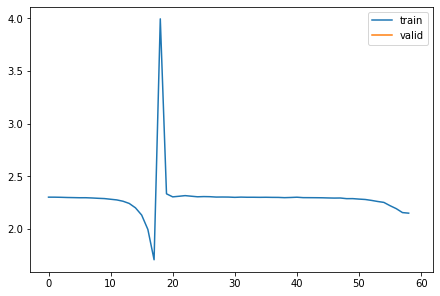

In [47]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);